In [1]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os

# Robust path finding for data.mat
current_path = Path.cwd()
possible_data_paths = [
    current_path / 'data' / 'data.mat',
    current_path.parent / 'data' / 'data.mat',
    current_path.parent.parent / 'data' / 'data.mat',
    # Fallback absolute path
    Path('/home/luky/skola/KalmanNet-for-state-estimation/data/data.mat')
]

dataset_path = None
for p in possible_data_paths:
    if p.exists():
        dataset_path = p
        break

if dataset_path is None or not dataset_path.exists():
    print("Warning: data.mat not found automatically.")
    dataset_path = Path('data/data.mat')

print(f"Dataset path: {dataset_path}")

# Add project root to sys.path (2 levels up from debug/test)
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"Project root added: {project_root}")

mat_data = loadmat(dataset_path)
print(mat_data.keys())


Dataset path: /home/luky/skola/KalmanNet-main/data/data.mat
Project root added: /home/luky/skola/KalmanNet-main
dict_keys(['__header__', '__version__', '__globals__', 'hB', 'souradniceGNSS', 'souradniceX', 'souradniceY', 'souradniceZ'])


In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [3]:
mat_data = loadmat(dataset_path)

souradniceX_mapa = mat_data['souradniceX']
souradniceY_mapa = mat_data['souradniceY']
souradniceZ_mapa = mat_data['souradniceZ']
souradniceGNSS = mat_data['souradniceGNSS'] 
x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]

print(f"Dimensions of 1D X axis: {x_axis_unique.shape}")
print(f"Dimensions of 1D Y axis: {y_axis_unique.shape}")
print(f"Dimensions of 2D elevation data Z: {souradniceZ_mapa.shape}")

terMap_interpolator = RegularGridInterpolator(
    (y_axis_unique, x_axis_unique),
    souradniceZ_mapa,
    bounds_error=False, 
    fill_value=np.nan
)

def terMap(px, py):
    # Query bilinear interpolation over the terrain map
    points_to_query = np.column_stack((py, px))
    return terMap_interpolator(points_to_query)

Dimensions of 1D X axis: (2500,)
Dimensions of 1D Y axis: (2500,)
Dimensions of 2D elevation data Z: (2500, 2500)


In [4]:
import torch
from Systems import DynamicSystemTAN

state_dim = 4
obs_dim = 3
dT = 1
q = 9.057863

F = torch.tensor([[1.0, 0.0, dT, 0.0],
                   [0.0, 1.0, 0.0, dT],
                   [0.0, 0.0, 1.0, 0.0],
                   [0.0, 0.0, 0.0, 1.0]])

Q = q* torch.tensor([[dT**3/3, 0.0, dT**2/2, 0.0],
                   [0.0, dT**3/3, 0.0, dT**2/2],
                   [dT**2/2, 0.0, dT, 0.0],
                   [0.0, dT**2/2, 0.0, dT]])
R = torch.tensor([[5.0**2, 0.0, 0.0],
                   [0.0, 1.0**2, 0.0],
                   [0.0, 0.0, 1.0**2]])

initial_velocity_np = souradniceGNSS[:2, 1] - souradniceGNSS[:2, 0]
# initial_velocity_np = torch.from_numpy()
initial_velocity = torch.from_numpy(np.array([0,0]))

initial_position = torch.from_numpy(souradniceGNSS[:2, 0])
x_0 = torch.cat([
    initial_position,
    initial_velocity
]).float()
print(x_0)

P_0 = torch.tensor([[25.0, 0.0, 0.0, 0.0],
                    [0.0, 25.0, 0.0, 0.0],
                    [0.0, 0.0, 0.5, 0.0],
                    [0.0, 0.0, 0.0, 0.5]])
import torch.nn.functional as func

def h_nl_differentiable(x: torch.Tensor, map_tensor, x_min, x_max, y_min, y_max) -> torch.Tensor:
    batch_size = x.shape[0]

    px = x[:, 0]
    py = x[:, 1]

    px_norm = 2.0 * (px - x_min) / (x_max - x_min) - 1.0
    py_norm = 2.0 * (py - y_min) / (y_max - y_min) - 1.0

    sampling_grid = torch.stack((px_norm, py_norm), dim=1).view(batch_size, 1, 1, 2)

    vyska_terenu_batch = func.grid_sample(
        map_tensor.expand(batch_size, -1, -1, -1),
        sampling_grid, 
        mode='bilinear', 
        padding_mode='border',
        align_corners=True
    )

    vyska_terenu = vyska_terenu_batch.view(batch_size)

    eps = 1e-12
    vx_w, vy_w = x[:, 2], x[:, 3]
    norm_v_w = torch.sqrt(vx_w**2 + vy_w**2).clamp(min=eps)
    cos_psi = vx_w / norm_v_w
    sin_psi = vy_w / norm_v_w

    vx_b = cos_psi * vx_w - sin_psi * vy_w 
    vy_b = sin_psi * vx_w + cos_psi * vy_w

    result = torch.stack([vyska_terenu, vx_b, vy_b], dim=1)

    return result

x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]
terMap_tensor = torch.from_numpy(souradniceZ_mapa).float().unsqueeze(0).unsqueeze(0).to(device)
x_min, x_max = x_axis_unique.min(), x_axis_unique.max()
y_min, y_max = y_axis_unique.min(), y_axis_unique.max()

h_wrapper = lambda x: h_nl_differentiable(
    x, 
    map_tensor=terMap_tensor, 
    x_min=x_min, 
    x_max=x_max, 
    y_min=y_min, 
    y_max=y_max
)

system_model = DynamicSystemTAN(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q.float(),
    R=R.float(),
    Ex0=x_0.float(),
    P0=P_0.float(),
    F=F.float(),
    h=h_wrapper,
    x_axis_unique=x_axis_unique, 
    y_axis_unique=y_axis_unique,
    device=device
)

tensor([1487547.1250, 6395520.5000,       0.0000,       0.0000])
INFO: DynamicSystemTAN inicializován s hranicemi mapy:
  X: [1476611.42, 1489541.47]
  Y: [6384032.63, 6400441.34]


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from utils import utils
import torch
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
from copy import deepcopy
from utils import trainer 

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [6]:
from state_NN_models import TAN

state_knet2 = TAN.StateKalmanNetTAN(
        system_model=system_model, 
        device=device,
        hidden_size_multiplier=12,       
        output_layer_multiplier=4,
        num_gru_layers=1,
        gru_hidden_dim_multiplier=4      
).to(device)

import os
import torch

# ==========================================
# 1. NASTAVENÍ NÁZVŮ SOUBORŮ (Manuální vstup)
# ==========================================
# Složka, kde jsou váhy uloženy
WEIGHTS_DIR = 'weights'

# Zde doplň přesné názvy souborů .pth
# KNET_FILENAME = 'best_Knet_test_results.pth'                                          # Příklad
KNET_FILENAME = 'knet_curriculum_model_vyrovnane_s_UKF.pth' #best_MSE_KalmanNet_linear_trajectory
# BKN_FILENAME = 'best_MSE_BayesianKalmanNet_linear_trajectory-MSE2.3662|ANEES7.9216.pth'  

# ==========================================
# 2. FUNKCE PRO BEZPEČNÉ NAČTENÍ
# ==========================================
def load_pretrained_weights(model, filename, model_name):
    filepath = os.path.join(WEIGHTS_DIR, filename)
    
    if not os.path.exists(filepath):
        print(f"⚠️  VAROVÁNÍ: Soubor '{filename}' pro {model_name} nebyl nalezen v '{WEIGHTS_DIR}'.")
        return

    try:
        # Načtení na správné zařízení (CPU/GPU)
        checkpoint = torch.load(filepath, map_location=device)
        
        # Detekce, zda jde o čistý state_dict nebo slovník checkpointu
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            # Pokud je to checkpoint z traineru, vytáhneme jen váhy modelu
            state_dict = checkpoint['model_state_dict']
        elif isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            # Předpokládáme, že je to přímo state_dict
            state_dict = checkpoint

        # Nahrání vah do modelu
        model.load_state_dict(state_dict)
        
        # Důležité: Přepnutí do evaluačního módu (vypne Dropout, fixuje BatchNorm)
        model.eval()
        
        print(f"✅ {model_name}: Váhy úspěšně načteny z '{filename}'.")
        
    except Exception as e:
        print(f"❌ CHYBA: Nepodařilo se načíst váhy pro {model_name}.\n   Důvod: {e}")

# ==========================================
# 3. SPUŠTĚNÍ NAČÍTÁNÍ
# ==========================================
print(f"--- Načítání vah ze složky: {os.path.abspath(WEIGHTS_DIR)} ---\n")

# Načtení State KalmanNet
load_pretrained_weights(state_knet2, KNET_FILENAME, "State KalmanNet")

# Načtení Bayesian KalmanNet
# load_pretrained_weights(state_bkn, BKN_FILENAME, "State BKN")

print("\n--- Hotovo ---")

DEBUG: Layer 'output_final_linear.0' initialized near zero (Start K=0).
--- Načítání vah ze složky: /home/luky/skola/KalmanNet-main/TAN/synthetic_data_only/weights ---

✅ State KalmanNet: Váhy úspěšně načteny z 'knet_curriculum_model_vyrovnane_s_UKF.pth'.

--- Hotovo ---


# Test na synteticke trajektorii

=== VYHODNOCENÍ NA TESTOVACÍ SADĚ ===
Načítám data z: ./generated_data_synthetic_controlled/test_set/test.pt
Počet testovacích trajektorií: 10
Délka sekvence: 1000
Modely: KalmanNet vs. UKF vs. PF


Processing PF (GPU): 100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


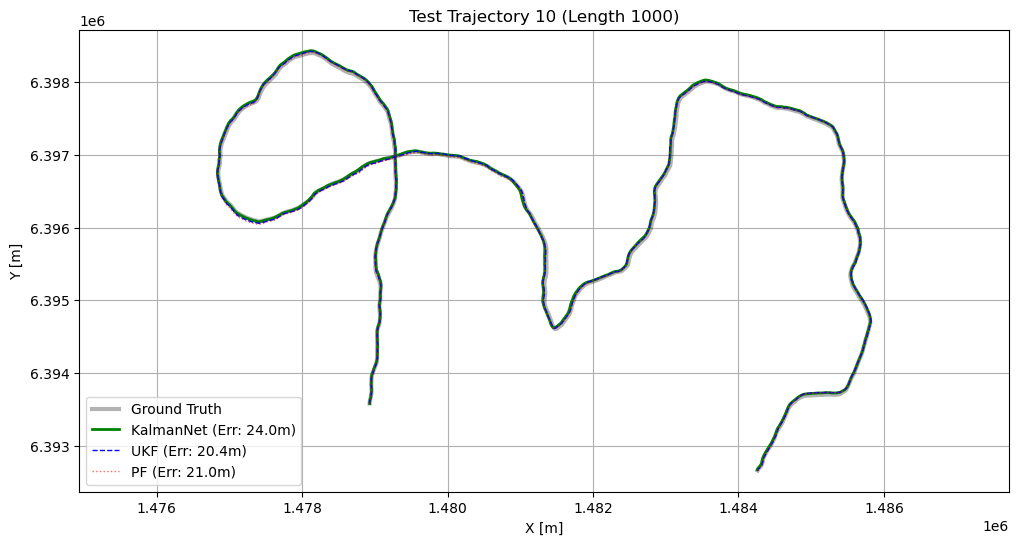


DETAILNÍ VÝSLEDKY PO JEDNOTLIVÝCH TRAJEKTORIÍCH
   Run_ID  KNet_MSE  UKF_MSE   PF_MSE  KNet_PosErr  UKF_PosErr  PF_PosErr
0       1    277.00   729.94   471.09        14.88       23.09      18.17
1       2  3,204.16   449.83   392.52        48.82       18.49      16.63
2       3    500.93   998.28   574.55        20.65       25.91      20.15
3       4    581.66 4,200.47 1,839.86        22.07       55.08      36.97
4       5    707.42   310.96   228.69        20.03       15.93      13.47
5       6  1,305.57   630.71   308.27        31.53       22.02      15.91
6       7  1,271.00   693.37   828.52        31.81       24.33      25.47
7       8    465.20   612.17   655.32        18.75       21.98      23.94
8       9  2,553.20   824.37   475.47        45.29       26.60      19.31
9      10    639.80   506.56   570.21        23.97       20.36      21.01

SOUHRNNÁ STATISTIKA (10 trajektorií)
Model           | MSE (Mean ± Std)          | Pos Error (Mean ± Std)   
---------------------------

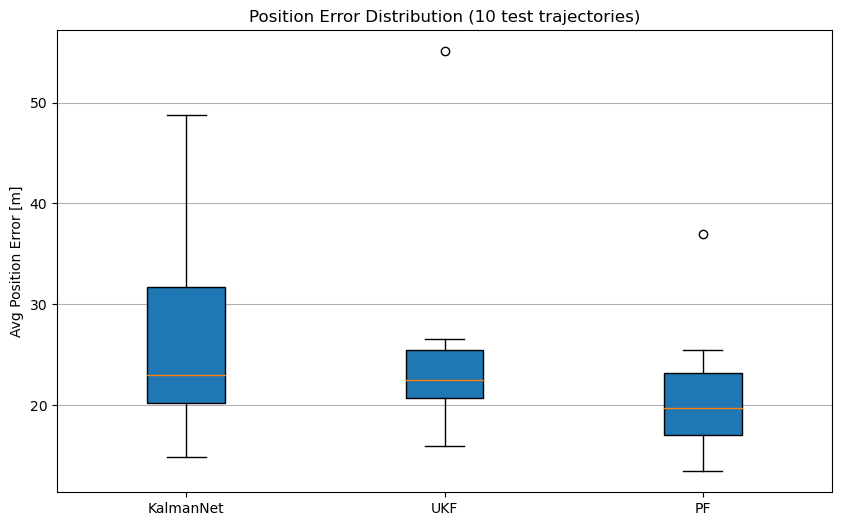

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Filters
import os
from tqdm import tqdm

# === KONFIGURACE ===
TEST_DATA_PATH = './generated_data_synthetic_controlled/test_set/test.pt'
PLOT_PER_ITERATION = False  # Vykreslovat graf pro každou trajektorii?
MAX_TEST_SAMPLES = 10      # Kolik trajektorií z test setu vyhodnotit (max 10, co jsme vygenerovali)

print(f"=== VYHODNOCENÍ NA TESTOVACÍ SADĚ ===")
print(f"Načítám data z: {TEST_DATA_PATH}")

# 1. Načtení Testovací sady
if not os.path.exists(TEST_DATA_PATH):
    raise FileNotFoundError(f"Soubor {TEST_DATA_PATH} neexistuje! Spusťte generování testovací sady.")

test_data = torch.load(TEST_DATA_PATH, map_location=device)
X_test_all = test_data['x']  # Ground Truth [N, Seq, 4]
Y_test_all = test_data['y']  # Measurements [N, Seq, 3]

n_samples = min(X_test_all.shape[0], MAX_TEST_SAMPLES)
print(f"Počet testovacích trajektorií: {n_samples}")
print(f"Délka sekvence: {X_test_all.shape[1]}")
print("Modely: KalmanNet vs. UKF vs. PF")

# 2. Inicializace pro sběr dat
detailed_results = []
agg_mse = {"KNet": [], "UKF": [], "PF": []}
agg_pos = {"KNet": [], "UKF": [], "PF": []}

# Ujistíme se, že KNet je v eval módu
state_knet2.eval()

# --- HLAVNÍ SMYČKA (Iterace přes testovací trajektorie) ---
for i in range(n_samples):
    
    # A) Příprava dat pro tento běh
    x_gt_tensor = X_test_all[i]      # [Seq, 4]
    y_obs_tensor = Y_test_all[i]     # [Seq, 3]
    
    x_gt = x_gt_tensor.cpu().numpy()
    seq_len = x_gt.shape[0]
    
    # Skutečný startovní stav (pro inicializaci filtrů)
    true_init_state = x_gt_tensor[0] # [4]
    
    # B) Inference: KalmanNet
    # KNet očekává [Batch, Seq, Dim], takže musíme přidat dimenzi
    with torch.no_grad():
        initial_state_batch = true_init_state.unsqueeze(0) # [1, 4]
        
        # Reset stavu sítě
        state_knet2.reset(batch_size=1, initial_state=initial_state_batch)
        
        knet_preds = []
        # KNet zpracovává sekvenci krok po kroku (nebo bychom mohli upravit forward na celou sekvenci)
        # Zde zachováme logiku step-by-step pro konzistenci
        
        # Vstup y_obs_tensor má tvar [Seq, 3]. Potřebujeme [1, 3] pro každý krok
        y_input_batch = y_obs_tensor.unsqueeze(0) # [1, Seq, 3]
        
        for t in range(1, seq_len):
            y_t = y_input_batch[:, t, :] # [1, 3]
            x_est = state_knet2.step(y_t)
            knet_preds.append(x_est)
            
        # Složení predikce (přidáme počáteční stav)
        if len(knet_preds) > 0:
            knet_preds_tensor = torch.stack(knet_preds, dim=1) # [1, Seq-1, 4]
            full_knet_est = torch.cat([initial_state_batch.unsqueeze(1), knet_preds_tensor], dim=1)
        else:
            full_knet_est = initial_state_batch.unsqueeze(1)
            
        x_est_knet = full_knet_est.squeeze().cpu().numpy()

    # C) Inference: UKF & PF
    # Filtry očekávají [Seq, Dim] (bez batch dimenze, pokud tak byly napsány)
    
    # UKF
    ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
    ukf_res = ukf_ideal.process_sequence(
        y_seq=y_obs_tensor,
        Ex0=true_init_state, 
        P0=system_model.P0
    )
    x_est_ukf = ukf_res['x_filtered'].cpu().numpy()

    # PF (Snížil jsem počet částic na 2000 pro rychlost, pro finální diplomku dejte více)
    pf = Filters.VectorizedParticleFilter(system_model, num_particles=4372281) 
    pf_res = pf.process_sequence(
        y_seq=y_obs_tensor,
        Ex0=true_init_state, 
        P0=system_model.P0
    )
    x_est_pf = pf_res['x_filtered'].cpu().numpy()

    
    # D) Výpočet chyb
    # Ořežeme na délku min(odhad, gt) pro jistotu
    min_len = min(len(x_gt), len(x_est_knet), len(x_est_ukf))
    
    # KNet
    diff_knet = x_est_knet[:min_len] - x_gt[:min_len]
    mse_knet = np.mean(np.sum(diff_knet[:, :2]**2, axis=1)) # Pouze XY chyba
    pos_err_knet = np.mean(np.sqrt(diff_knet[:, 0]**2 + diff_knet[:, 1]**2))
    
    # UKF
    diff_ukf = x_est_ukf[:min_len] - x_gt[:min_len]
    mse_ukf = np.mean(np.sum(diff_ukf[:, :2]**2, axis=1))
    pos_err_ukf = np.mean(np.sqrt(diff_ukf[:, 0]**2 + diff_ukf[:, 1]**2))
    
    # PF
    diff_pf = x_est_pf[:min_len] - x_gt[:min_len]
    mse_pf = np.mean(np.sum(diff_pf[:, :2]**2, axis=1))
    pos_err_pf = np.mean(np.sqrt(diff_pf[:, 0]**2 + diff_pf[:, 1]**2))
    
    # Uložení
    agg_mse["KNet"].append(mse_knet)
    agg_pos["KNet"].append(pos_err_knet)
    agg_mse["UKF"].append(mse_ukf)
    agg_pos["UKF"].append(pos_err_ukf)
    agg_mse["PF"].append(mse_pf)
    agg_pos["PF"].append(pos_err_pf)

    detailed_results.append({
        "Run_ID": i + 1,
        "KNet_MSE": mse_knet,
        "UKF_MSE": mse_ukf,
        "PF_MSE": mse_pf,
        "KNet_PosErr": pos_err_knet,
        "UKF_PosErr": pos_err_ukf,
        "PF_PosErr": pos_err_pf
    })
    
    # E) Vykreslení
    if PLOT_PER_ITERATION or (i == n_samples - 1):
        fig = plt.figure(figsize=(12, 6))
        # Vykreslíme jen XY trajektorii
        plt.plot(x_gt[:, 0], x_gt[:, 1], 'k-', linewidth=3, alpha=0.3, label='Ground Truth')
        plt.plot(x_est_knet[:, 0], x_est_knet[:, 1], 'g-', linewidth=2, label=f'KalmanNet (Err: {pos_err_knet:.1f}m)')
        plt.plot(x_est_ukf[:, 0], x_est_ukf[:, 1], 'b--', linewidth=1, label=f'UKF (Err: {pos_err_ukf:.1f}m)')
        plt.plot(x_est_pf[:, 0], x_est_pf[:, 1], 'r:', linewidth=1, alpha=0.6, label=f'PF (Err: {pos_err_pf:.1f}m)')
        
        plt.title(f"Test Trajectory {i+1} (Length {seq_len})")
        plt.xlabel("X [m]")
        plt.ylabel("Y [m]")
        plt.legend()
        plt.axis('equal')
        plt.grid(True)
        plt.show()

# --- VÝPIS VÝSLEDKŮ ---
df_results = pd.DataFrame(detailed_results)
print("\n" + "="*80)
print(f"DETAILNÍ VÝSLEDKY PO JEDNOTLIVÝCH TRAJEKTORIÍCH")
print("="*80)
pd.options.display.float_format = '{:,.2f}'.format
print(df_results[["Run_ID", "KNet_MSE", "UKF_MSE", "PF_MSE", "KNet_PosErr", "UKF_PosErr", "PF_PosErr"]])

print("\n" + "="*80)
print(f"SOUHRNNÁ STATISTIKA ({n_samples} trajektorií)")
print("="*80)

def get_stats(key):
    return np.mean(agg_mse[key]), np.std(agg_mse[key]), np.mean(agg_pos[key]), np.std(agg_pos[key])

knet_stats = get_stats("KNet")
ukf_stats = get_stats("UKF")
pf_stats = get_stats("PF")

print(f"{'Model':<15} | {'MSE (Mean ± Std)':<25} | {'Pos Error (Mean ± Std)':<25}")
print("-" * 75)
print(f"{'KalmanNet':<15} | {knet_stats[0]:.1f} ± {knet_stats[1]:.1f} | {knet_stats[2]:.2f} ± {knet_stats[3]:.2f} m")
print(f"{'UKF':<15} | {ukf_stats[0]:.1f} ± {ukf_stats[1]:.1f} | {ukf_stats[2]:.2f} ± {ukf_stats[3]:.2f} m")
print(f"{'PF':<15} | {pf_stats[0]:.1f} ± {pf_stats[1]:.1f} | {pf_stats[2]:.2f} ± {pf_stats[3]:.2f} m")
print("="*80)

plt.figure(figsize=(10, 6))
plt.boxplot([agg_pos["KNet"], agg_pos["UKF"], agg_pos["PF"]], labels=['KalmanNet', 'UKF', 'PF'], patch_artist=True)
plt.title(f"Position Error Distribution ({n_samples} test trajectories)")
plt.ylabel("Avg Position Error [m]")
plt.grid(True, axis='y')
plt.show()

## PF analýza

In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# import Filters
# import os
# from tqdm import tqdm

# # === KONFIGURACE ===
# TEST_DATA_PATH = './generated_data_synthetic_controlled/test_set/test.pt'
# PLOT_PER_ITERATION = False  # Vykreslovat graf pro každou trajektorii?
# MAX_TEST_SAMPLES = 2      # Kolik trajektorií z test setu vyhodnotit (max 10, co jsme vygenerovali)

# print(f"=== VYHODNOCENÍ NA TESTOVACÍ SADĚ ===")
# print(f"Načítám data z: {TEST_DATA_PATH}")

# # 1. Načtení Testovací sady
# if not os.path.exists(TEST_DATA_PATH):
#     raise FileNotFoundError(f"Soubor {TEST_DATA_PATH} neexistuje! Spusťte generování testovací sady.")

# test_data = torch.load(TEST_DATA_PATH, map_location=device)
# X_test_all = test_data['x']  # Ground Truth [N, Seq, 4]
# Y_test_all = test_data['y']  # Measurements [N, Seq, 3]

# n_samples = min(X_test_all.shape[0], MAX_TEST_SAMPLES)
# print(f"Počet testovacích trajektorií: {n_samples}")
# print(f"Délka sekvence: {X_test_all.shape[1]}")
# print("Modely: KalmanNet vs. UKF vs. PF")

# # 2. Inicializace pro sběr dat
# detailed_results = []
# agg_mse = {"UKF": [], "PF": [],"PF_Aux": []}
# agg_pos = {"UKF": [], "PF": [], "PF_Aux": []}

# # --- HLAVNÍ SMYČKA (Iterace přes testovací trajektorie) ---
# for i in tqdm(range(n_samples), desc="Evaluace"):
    
#     # A) Příprava dat pro tento běh
#     x_gt_tensor = X_test_all[i]      # [Seq, 4]
#     y_obs_tensor = Y_test_all[i]     # [Seq, 3]
    
#     x_gt = x_gt_tensor.cpu().numpy()
#     seq_len = x_gt.shape[0]
    
#     # Skutečný startovní stav (pro inicializaci filtrů)
#     true_init_state = x_gt_tensor[0] # [4]

#     # C) Inference: UKF & PF
#     # Filtry očekávají [Seq, Dim] (bez batch dimenze, pokud tak byly napsány)
    
#     # UKF
#     ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
#     ukf_res = ukf_ideal.process_sequence(
#         y_seq=y_obs_tensor,
#         Ex0=true_init_state, 
#         P0=system_model.P0
#     )
#     x_est_ukf = ukf_res['x_filtered'].cpu().numpy()

#     # PF (Snížil jsem počet částic na 2000 pro rychlost, pro finální diplomku dejte více)
#     pf = Filters.VectorizedParticleFilter(system_model, num_particles=100000) 
#     pf_res = pf.process_sequence(
#         y_seq=y_obs_tensor,
#         Ex0=true_init_state, 
#         P0=system_model.P0
#     )
#     x_est_pf = pf_res['x_filtered'].cpu().numpy()

#     pf_aux = Filters.VectorizedAuxiliaryParticleFilter(system_model, num_particles=100000)
#     pf_aux_res = pf_aux.process_sequence(
#         y_seq=y_obs_tensor,
#         Ex0=true_init_state, 
#         P0=system_model.P0
#     )
#     x_est_pf_aux = pf_aux_res['x_filtered'].cpu().numpy()
    
#     # D) Výpočet chyb
#     # Ořežeme na délku min(odhad, gt) pro jistotu
#     min_len = min(len(x_gt), len(x_est_ukf))
    
#     # UKF
#     diff_ukf = x_est_ukf[:min_len] - x_gt[:min_len]
#     mse_ukf = np.mean(np.sum(diff_ukf[:, :2]**2, axis=1))
#     pos_err_ukf = np.mean(np.sqrt(diff_ukf[:, 0]**2 + diff_ukf[:, 1]**2))
    
#     # PF
#     diff_pf = x_est_pf[:min_len] - x_gt[:min_len]
#     mse_pf = np.mean(np.sum(diff_pf[:, :2]**2, axis=1))
#     pos_err_pf = np.mean(np.sqrt(diff_pf[:, 0]**2 + diff_pf[:, 1]**2))
    
#     diff_pf_aux = x_est_pf_aux[:min_len] - x_gt[:min_len]
#     mse_pf_aux = np.mean(np.sum(diff_pf_aux[:, :2]**2, axis=1))
#     pos_err_pf_aux = np.mean(np.sqrt(diff_pf_aux[:, 0]**2 + diff_pf_aux[:, 1]**2))

#     # Uložení
#     agg_mse["UKF"].append(mse_ukf)
#     agg_pos["UKF"].append(pos_err_ukf)
#     agg_mse["PF"].append(mse_pf)
#     agg_pos["PF"].append(pos_err_pf)
#     agg_mse["PF_Aux"].append(mse_pf_aux)
#     agg_pos["PF_Aux"].append(pos_err_pf_aux)

#     detailed_results.append({
#         "Run_ID": i + 1,
#         "UKF_MSE": mse_ukf,
#         "PF_MSE": mse_pf,
#         "UKF_PosErr": pos_err_ukf,
#         "PF_PosErr": pos_err_pf,
#         "PF_Aux_MSE": mse_pf_aux,
#         "PF_Aux_PosErr": pos_err_pf_aux
#     })
    
#     # E) Vykreslení
#     if PLOT_PER_ITERATION or (i == n_samples - 1):
#         fig = plt.figure(figsize=(12, 6))
#         # Vykreslíme jen XY trajektorii
#         plt.plot(x_gt[:, 0], x_gt[:, 1], 'k-', linewidth=3, alpha=0.3, label='Ground Truth')
#         plt.plot(x_est_ukf[:, 0], x_est_ukf[:, 1], 'b--', linewidth=1, label=f'UKF (Err: {pos_err_ukf:.1f}m)')
#         plt.plot(x_est_pf[:, 0], x_est_pf[:, 1], 'r:', linewidth=1, alpha=0.6, label=f'PF (Err: {pos_err_pf:.1f}m)')
#         plt.plot(x_est_pf_aux[:, 0], x_est_pf_aux[:, 1], 'g-.', linewidth=1, alpha=0.6, label=f'PF Aux (Err: {pos_err_pf_aux:.1f}m)')
#         plt.title(f"Test Trajectory {i+1} (Length {seq_len})")
#         plt.xlabel("X [m]")
#         plt.ylabel("Y [m]")
#         plt.legend()
#         plt.axis('equal')
#         plt.grid(True)
#         plt.show()

# # --- VÝPIS VÝSLEDKŮ ---
# df_results = pd.DataFrame(detailed_results)
# print("\n" + "="*80)
# print(f"DETAILNÍ VÝSLEDKY PO JEDNOTLIVÝCH TRAJEKTORIÍCH")
# print("="*80)
# pd.options.display.float_format = '{:,.2f}'.format
# print(df_results[["Run_ID", "UKF_MSE", "PF_MSE", "PF_Aux_MSE", "UKF_PosErr", "PF_PosErr", "PF_Aux_PosErr"]])

# print("\n" + "="*80)
# print(f"SOUHRNNÁ STATISTIKA ({n_samples} trajektorií)")
# print("="*80)

# def get_stats(key):
#     return np.mean(agg_mse[key]), np.std(agg_mse[key]), np.mean(agg_pos[key]), np.std(agg_pos[key])

# ukf_stats = get_stats("UKF")
# pf_stats = get_stats("PF")
# pf_aux_stats = get_stats("PF_Aux")

# print(f"{'Model':<15} | {'MSE (Mean ± Std)':<25} | {'Pos Error (Mean ± Std)':<25}")
# print("-" * 75)
# print(f"{'UKF':<15} | {ukf_stats[0]:.1f} ± {ukf_stats[1]:.1f} | {ukf_stats[2]:.2f} ± {ukf_stats[3]:.2f} m")
# print(f"{'PF':<15} | {pf_stats[0]:.1f} ± {pf_stats[1]:.1f} | {pf_stats[2]:.2f} ± {pf_stats[3]:.2f} m")
# print(f"{'PF Aux':<15} | {pf_aux_stats[0]:.1f} ± {pf_aux_stats[1]:.1f} | {pf_aux_stats[2]:.2f} ± {pf_aux_stats[3]:.2f} m")
# print("="*80)

# plt.figure(figsize=(10, 6))
# plt.boxplot([agg_pos["UKF"], agg_pos["PF"], agg_pos["PF_Aux"]], labels=['UKF', 'PF', 'PF Aux'], patch_artist=True)
# plt.title(f"Position Error Distribution ({n_samples} test trajectories)")
# plt.ylabel("Avg Position Error [m]")
# plt.grid(True, axis='y')
# plt.show()